In [153]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [21]:
pd.set_option('display.max_columns', None)

In [45]:
train_dt = pd.read_csv('train.csv')
train_dt.columns

Index(['ID', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [46]:
train_dt['arrival_date_full'] = train_dt['arrival_date_year'].astype(str) + "-" + train_dt['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + train_dt['arrival_date_day_of_month'].astype(str)
train_dt['arrival_date_full'] = pd.to_datetime(train_dt['arrival_date_full'], format="%Y-%m-%d")
train_dt['status_minus_arrival_date'] = train_dt['stays_in_week_nights'] + train_dt['stays_in_weekend_nights']


In [47]:
train_dt = train_dt.drop(columns=['ID','is_canceled','arrival_date_year',
                                  'arrival_date_month','reservation_status',
                                  'reservation_status_date','adr','agent','company'])

In [48]:
train_dt['country']=train_dt['country'].fillna(train_dt['country'].value_counts().index[0])
train_dt['children']=train_dt['children'].fillna(train_dt['children'].median())
#train_dt['company']=train_dt['company'].fillna(train_dt['company'].value_counts().index[0])

In [49]:
train_dt.isnull().sum().sum()

0

In [50]:
train_dt = pd.get_dummies(train_dt,columns=[ 'hotel','meal', 'market_segment', 
                                            'distribution_channel', 'reserved_room_type',
                                            'assigned_room_type', 'deposit_type', 
                                            'customer_type','country'])
train_dt = train_dt.groupby(train_dt.arrival_date_full).sum().astype(int)


,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,status_minus_arrival_date,hotel_City Hotel,hotel_Resort Hotel,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE
arrival_date_full,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-01,22783,3294,122,45,335,223,2,0,1,11,9,33,0,4,39,380,79,43,45,1,76,0,0,0,0,4,12,0,82,24,0,4,12,0,106,0,98,0,4,11,6,1,2,0,0,0,91,1,8,7,10,1,3,0,1,0,0,0,122,0,0,6,0,114,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [64]:
x = train_dt.values

In [117]:
test_dt = pd.read_csv('train_label.csv')
y = test_dt['label']
y = pd.get_dummies(y)

In [133]:
x_train, x_val, y_train, y_val = train_test_split(x,y,random_state=36,test_size=0.2)


In [134]:
ss = MinMaxScaler()
xs_train = ss.fit_transform(x_train)
xs_val = ss.transform(x_val)

In [135]:
xs_train

array([[0.28487436, 0.16802081, 0.25139665, ..., 0.        , 0.        ,
        0.        ],
       [0.28765447, 0.28993975, 0.06231199, ..., 0.        , 0.        ,
        0.        ],
       [0.07781635, 0.06509038, 0.29984959, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04993549, 0.07280445, 0.10732703, ..., 0.        , 0.        ,
        0.        ],
       [0.08744696, 0.34489684, 0.14224323, ..., 0.        , 0.        ,
        0.        ],
       [0.30934993, 0.13561256, 0.06725398, ..., 0.        , 0.        ,
        0.        ]])

In [136]:
y_train

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
351,0,0,0,1,0,0,0,0,0,0
461,0,0,1,0,0,0,0,0,0,0
270,0,1,0,0,0,0,0,0,0,0
575,0,1,0,0,0,0,0,0,0,0
360,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
439,0,0,0,1,0,0,0,0,0,0
293,0,1,0,0,0,0,0,0,0,0
250,0,0,1,0,0,0,0,0,0,0
161,1,0,0,0,0,0,0,0,0,0


In [149]:
y_val

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
279,0,1,0,0,0,0,0,0,0,0
309,0,0,0,1,0,0,0,0,0,0
260,0,0,1,0,0,0,0,0,0,0
465,0,0,1,0,0,0,0,0,0,0
451,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
409,0,0,0,0,0,0,1,0,0,0
374,0,0,0,0,1,0,0,0,0,0
128,0,1,0,0,0,0,0,0,0,0
441,0,0,1,0,0,0,0,0,0,0


In [127]:
rf_params = {
    'n_estimators': [1500],  
}

# Perform Grid Search
rf_gs = GridSearchCV(RandomForestClassifier(random_state=36),
                 rf_params,
                 cv = 5,
                 scoring = 'accuracy')
rf = rf_gs.fit(xs_train, y_train)
print(f'Best Training Accuracy: {rf.score(xs_train, y_train)}')
print(f'Best Testing Accuracy: {rf.score(xs_val, y_val)}')

ValueError: Found input variables with inconsistent numbers of samples: [512, 10]

In [122]:
dt_params = {
    'max_depth':[None],
    'max_features' : [200],
    'min_samples_split': [50], 
    'min_samples_leaf': [10]
}

# Perform Grid Search
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=49),
                 dt_params,
                 cv = 5,
                 scoring = 'accuracy')
dt = dt_gs.fit(xs_train, y_train)
print(f'Best Training Accuracy: {dt.score(xs_train, y_train)}')
print(f'Best Testing Accuracy: {dt.score(xs_val, y_val)}')

Best Training Accuracy: 0.44921875
Best Testing Accuracy: 0.2734375


In [123]:
ext = ExtraTreesClassifier(n_estimators=3000)
clf = ext.fit(xs_train,y_train)
print(f'Best Training Accuracy: {clf.score(xs_train, y_train)}')
print(f'Best Testing Accuracy: {clf.score(xs_val, y_val)}')

Best Training Accuracy: 1.0
Best Testing Accuracy: 0.1796875


In [130]:
xs_train.shape

(512, 228)

In [185]:
model = Sequential()
model.add(Dense(228,input_dim=228, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.37))
model.add(Dense(2345,activation='relu'))
model.add(Dropout(0.22))
model.add(Dense(10,activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 228)               52212     
_________________________________________________________________
dropout_14 (Dropout)         (None, 228)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2345)              537005    
_________________________________________________________________
dropout_15 (Dropout)         (None, 2345)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                23460     
Total params: 612,677
Trainable params: 612,677
Non-trainable params: 0
_________________________________________________________________


In [186]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(xs_train, y_train, epochs=30, batch_size=150,verbose=1, validation_split=0.2)
predictions = model.predict_classes(xs_val)

Epoch 1/30
3/3 [==============================] - 1s 86ms/step - loss: 2.2394 - accuracy: 0.1566 - val_loss: 1.9992 - val_accuracy: 0.2913
Epoch 2/30
3/3 [==============================] - 0s 27ms/step - loss: 1.9243 - accuracy: 0.2768 - val_loss: 1.8442 - val_accuracy: 0.2913
Epoch 3/30
3/3 [==============================] - 0s 24ms/step - loss: 1.7832 - accuracy: 0.2993 - val_loss: 1.8417 - val_accuracy: 0.2913
Epoch 4/30
3/3 [==============================] - 0s 24ms/step - loss: 1.7433 - accuracy: 0.3620 - val_loss: 1.8029 - val_accuracy: 0.3010
Epoch 5/30
3/3 [==============================] - 0s 24ms/step - loss: 1.6558 - accuracy: 0.4482 - val_loss: 1.7681 - val_accuracy: 0.3107
Epoch 6/30
3/3 [==============================] - 0s 24ms/step - loss: 1.5441 - accuracy: 0.5363 - val_loss: 1.6947 - val_accuracy: 0.3689
Epoch 7/30
3/3 [==============================] - 0s 24ms/step - loss: 1.4989 - accuracy: 0.4998 - val_loss: 1.5942 - val_accuracy: 0.3689
Epoch 8/30
3/3 [===========

/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


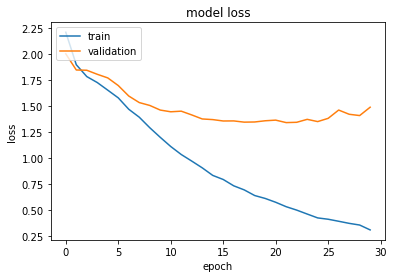

In [187]:

print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [188]:
from sklearn.preprocessing import OneHotEncoder

In [189]:
one = OneHotEncoder()
predictions = np.reshape(predictions,(-1,1))
print(one.fit(predictions))
predictions = one.transform(predictions).toarray()
pd.DataFrame(predictions)

OneHotEncoder()


,0,1,2,3,4,5
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
123,0.0,0.0,0.0,0.0,0.0,1.0
124,0.0,0.0,0.0,0.0,1.0,0.0
125,0.0,1.0,0.0,0.0,0.0,0.0
126,0.0,0.0,1.0,0.0,0.0,0.0


In [190]:
train_score = model.evaluate(xs_train,y_train)
test_score = model.evaluate(xs_val, y_val)
print('')
print(f'Loss: {train_score[0]}')
print(f'Training Accuracy: {train_score[1]}')
print(f'Loss: {test_score[0]}')
print(f'Testing Accuracy: {test_score[1]}')

4/4 [==============================] - 0s 2ms/step - loss: 2.2500 - accuracy: 0.4531

Loss: 0.49309179186820984
Training Accuracy: 0.859375
Loss: 2.2499842643737793
Testing Accuracy: 0.453125
